In [9]:
from trainer import Trainer
import constants


import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


/local/users/unjde


In [10]:

embeddings = {}
text_labels = []
raw_text_labels_files = []

for file_path in constants.file_paths:
    with open(file_path + "_embeddings_.json", "r") as f:
        embeddings_objects = json.load(f)
        for emb_obj in embeddings_objects:
            embeddings[emb_obj["hash"]] = np.array(emb_obj["embeddings"])

    with open(file_path + "_labeled_fewer_classes.json", "r") as f:
        text_labels_file = json.load(f)
        raw_text_labels_files.append({'ds': file_path, 'raw': text_labels_file})
        for text_hash, doc_info in text_labels_file.items():
            labels_list = [label["system"] for label in doc_info["label"]]
            text_labels.append((text_hash, labels_list))



In [11]:
# Assuming your initial data processing steps
filtered_embeddings = []
filtered_text_labels = []
doc_values_initial = []
doc_values = []

for item in raw_text_labels_files:
    raw_data = item.get('raw', {})
    for key, value in raw_data.items():
        doc_value = value.get('doc')
        if doc_value:
            doc_values_initial.append(doc_value)

for i, (sample_id, classes) in enumerate(text_labels):
    if classes:
        for label in classes:
            filtered_embeddings.append(embeddings[sample_id])
            filtered_text_labels.append(label)
            doc_values.append(doc_values_initial[i])



In [4]:
print(len(doc_values))

6951


In [5]:
!pip install top2vec nltk

In [6]:
!pip install top2vec[sentence_encoders]

In [2]:
from top2vec import Top2Vec


2024-09-23 14:26:35.338771: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 14:26:35.351346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 14:26:35.365678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 14:26:35.369934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 14:26:35.380625: I tensorflow/core/platform/cpu_feature_guar

In [3]:
model_path = 'model/topic2vec'

topic_model = Top2Vec.load(model_path)
topic_model.save(model_path)

In [4]:
topic_model.get_num_topics()

35

In [5]:
topic_words, word_scores, topic_nums = topic_model.get_topics(35)

In [11]:
document_topics, scores, words, topic_word_emb = topic_model.get_documents_topics(doc_ids=list(range(len(doc_values))))


In [12]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
document_topics_one_hot = one_hot_encoder.fit_transform(np.reshape(document_topics, (-1,1)))

In [13]:
document_topics_one_hot

<6951x35 sparse matrix of type '<class 'numpy.float64'>'
	with 6951 stored elements in Compressed Sparse Row format>

In [14]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(document_topics_one_hot).toarray()

In [15]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_text_labels)

X_emb_only = np.array(filtered_embeddings)

X_topics = np.array(sparse_matrix)

pca = PCA(n_components=100)

filtered_embeddings_pca = pca.fit_transform(filtered_embeddings)

X_combined_one_hot = np.hstack((X_topics, filtered_embeddings))

X_combined_one_hot_pca = np.hstack((X_topics, filtered_embeddings_pca))


X_combined_top_word_emb = np.hstack((topic_word_emb, filtered_embeddings))
X_combined_top_word_emb_pca = np.hstack((topic_word_emb, filtered_embeddings_pca))

X_topic_word_emb = topic_word_emb



In [16]:
document_topics = [[e] for e in document_topics]
print(len(document_topics))
len(X_topics)

6951


6951

In [17]:

X_combined_topic_num_PCA_emb = np.hstack((document_topics, filtered_embeddings))

In [18]:

assert len(filtered_text_labels) == len(sparse_matrix)

In [19]:
def evaluate(X, y):
    result = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    trainer = Trainer()
    trainer.train(X_train, y_train)

    predictions = trainer.predict(X_test)


    class_names = label_encoder.classes_

    for name, preds in predictions.items():
        accuracy, f1, recall, precision = trainer.evaluate(y_test, preds)
        result[name] = {'accuracy': accuracy, 'f1': f1, 'recall': recall, 'precision': precision}
        print(f"{name} accuracy: {accuracy}, f1 score: {f1}, recall: {recall}, precision: {precision}")

    for name, preds in predictions.items():
        cm = confusion_matrix(y_test, preds)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

    print(trainer.get_best_params())
    return result

In [20]:
results_dict = {}

----------------- evaluate: doc emb only ---------------------
Training dummy_mf...


Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.15148609779482264, f1 score: 0.16511102725841903, recall: 0.15148609779482264, precision: 0.20001832463569935
random_forest accuracy: 0.45397890699904125, f1 score: 0.41428128515056195, recall: 0.45397890699904125, precision: 0.41214420077129865
svm accuracy: 0.48801534036433364, f1 score: 0.4278084416206568, recall: 0.48801534036433364, precision: 0.4030809197922005
knn accuracy: 0.4419942473633749, f1 score: 0.42771127131750153, recall: 0.4419942473633749, precision: 0.4198554123043881
mlp accuracy: 0.473633748801534, f1 score: 0.45716624868688, recall: 0.473633748801534, precision: 0.4494866873402737


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


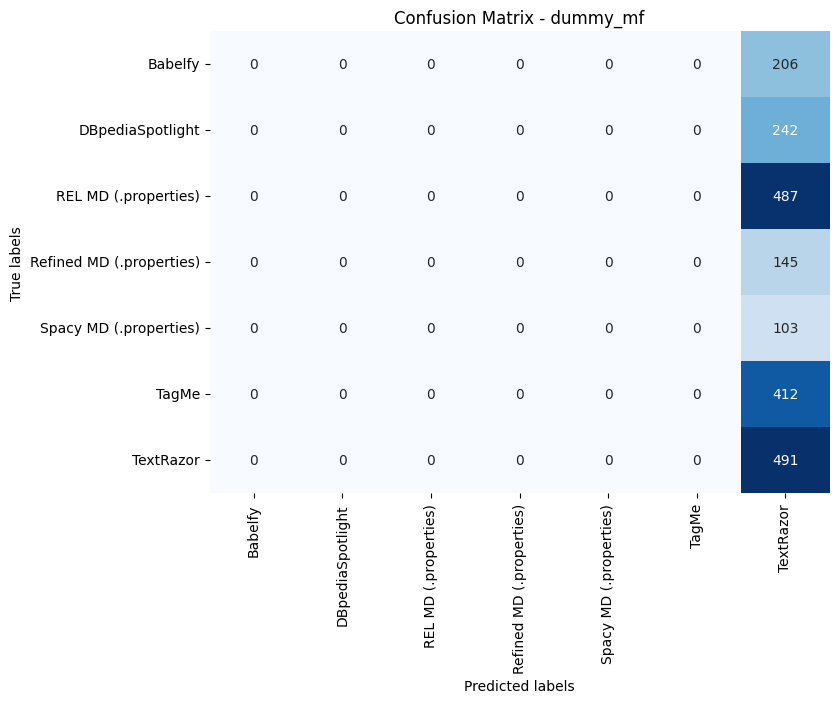

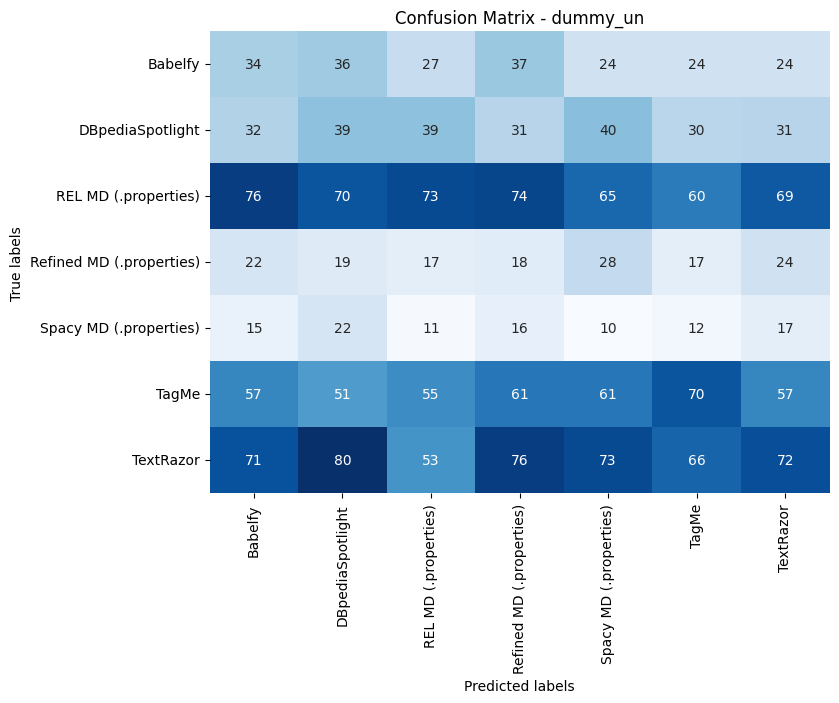

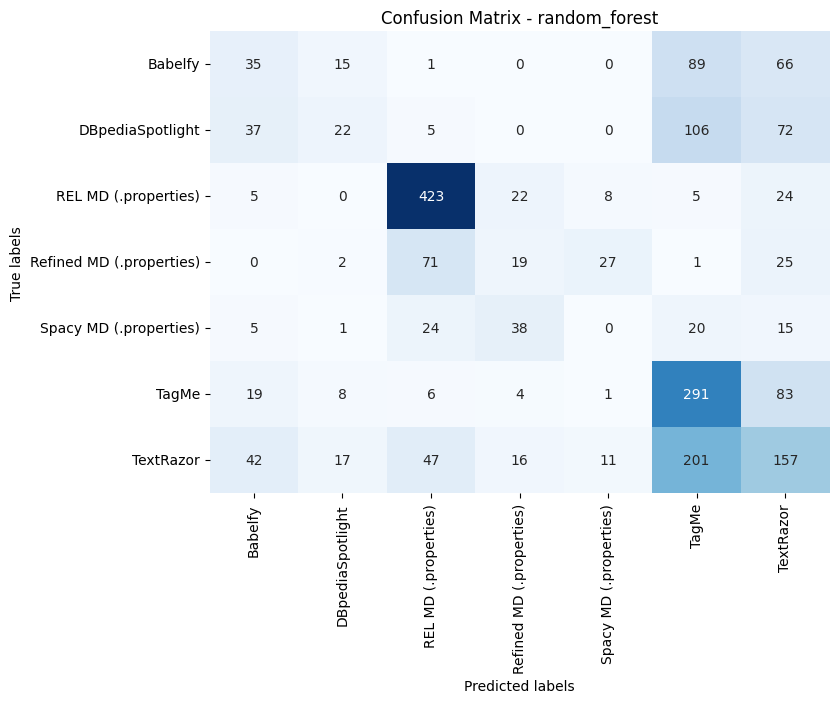

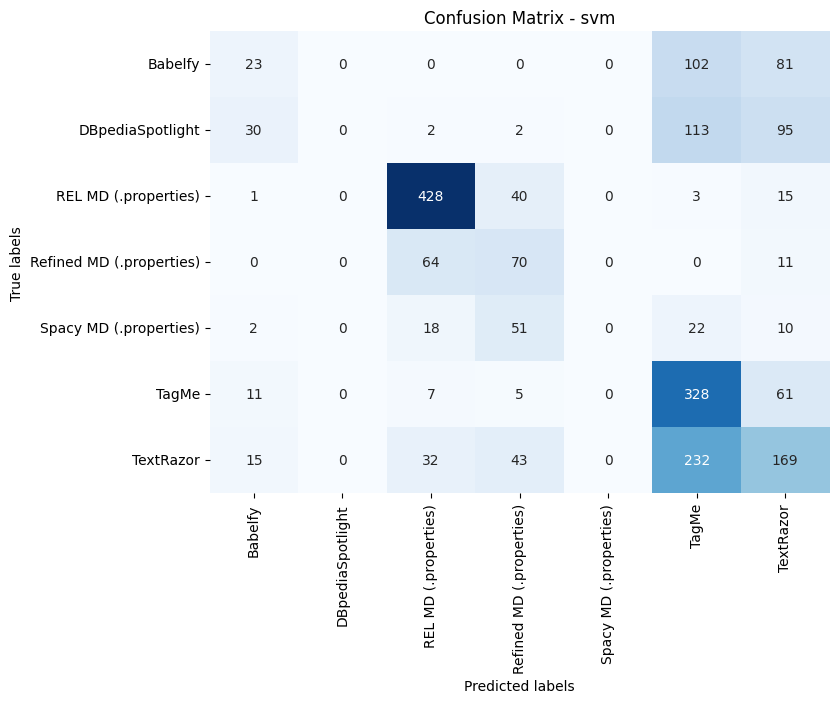

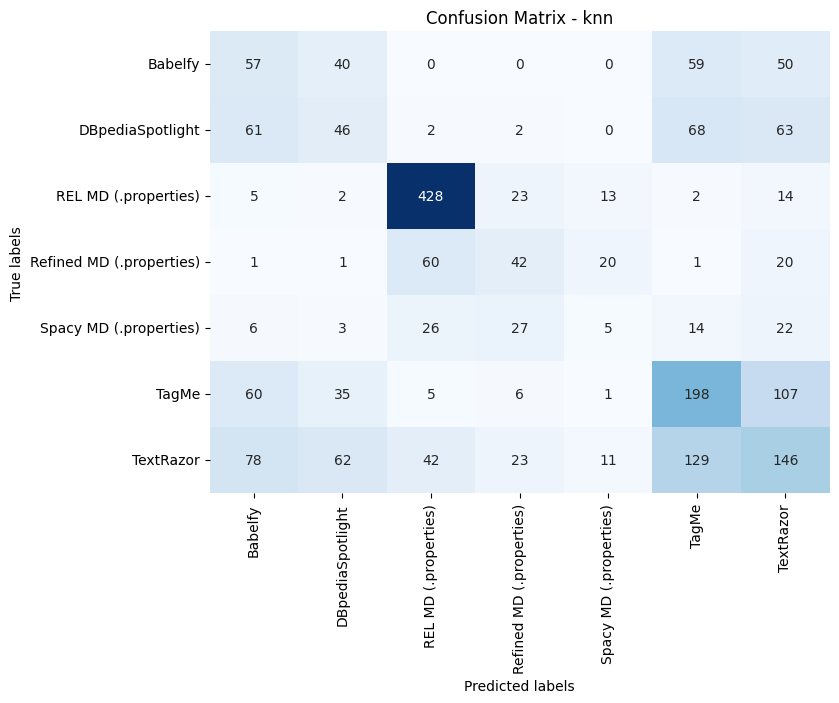

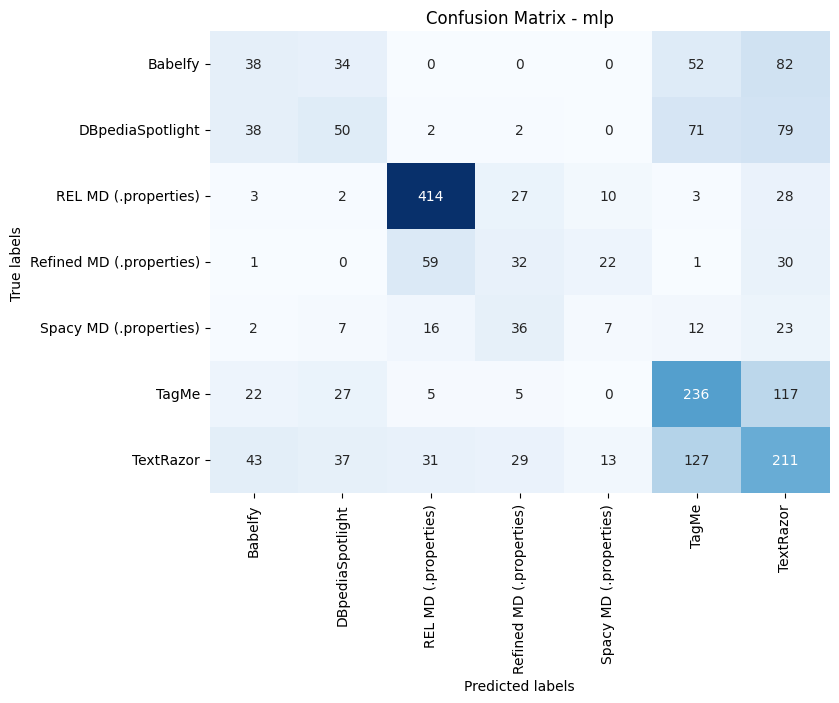

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 20, 'n_estimators': 200}, 'svm': {'C': 1, 'kernel': 'rbf'}, 'knn': {'n_neighbors': 7, 'p': 2}, 'mlp': {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}}


In [21]:
print("----------------- evaluate: doc emb only ---------------------")
results_dict['docEmbOnly'] = evaluate(X_emb_only, y)

In [22]:
results_dict

{'docEmbOnly': {'dummy_mf': {'accuracy': 0.23537871524448706,
   'f1': 0.08969417864574555,
   'recall': 0.23537871524448706,
   'precision': 0.055403139590145326},
  'dummy_un': {'accuracy': 0.15148609779482264,
   'f1': 0.16511102725841903,
   'recall': 0.15148609779482264,
   'precision': 0.20001832463569935},
  'random_forest': {'accuracy': 0.45397890699904125,
   'f1': 0.41428128515056195,
   'recall': 0.45397890699904125,
   'precision': 0.41214420077129865},
  'svm': {'accuracy': 0.48801534036433364,
   'f1': 0.4278084416206568,
   'recall': 0.48801534036433364,
   'precision': 0.4030809197922005},
  'knn': {'accuracy': 0.4419942473633749,
   'f1': 0.42771127131750153,
   'recall': 0.4419942473633749,
   'precision': 0.4198554123043881},
  'mlp': {'accuracy': 0.473633748801534,
   'f1': 0.45716624868688,
   'recall': 0.473633748801534,
   'precision': 0.4494866873402737}}}

----------------- evaluate: combined one one encoding (noisy) ---------------------
Training dummy_mf...
Training dummy_un...
Training random_forest...


Training svm...
Training knn...
Training mlp...


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.15148609779482264, f1 score: 0.16191320939558865, recall: 0.15148609779482264, precision: 0.19129896031266463
random_forest accuracy: 0.4482262703739214, f1 score: 0.40194755944587435, recall: 0.4482262703739214, precision: 0.39763135918785125
svm accuracy: 0.48801534036433364, f1 score: 0.42833964015511183, recall: 0.48801534036433364, precision: 0.4049273337144312
knn accuracy: 0.4463087248322148, f1 score: 0.4289779422419882, recall: 0.4463087248322148, precision: 0.4188037975519406
mlp accuracy: 0.473633748801534, f1 score: 0.45273568640188877, recall: 0.473633748801534, precision: 0.4487974056395031


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


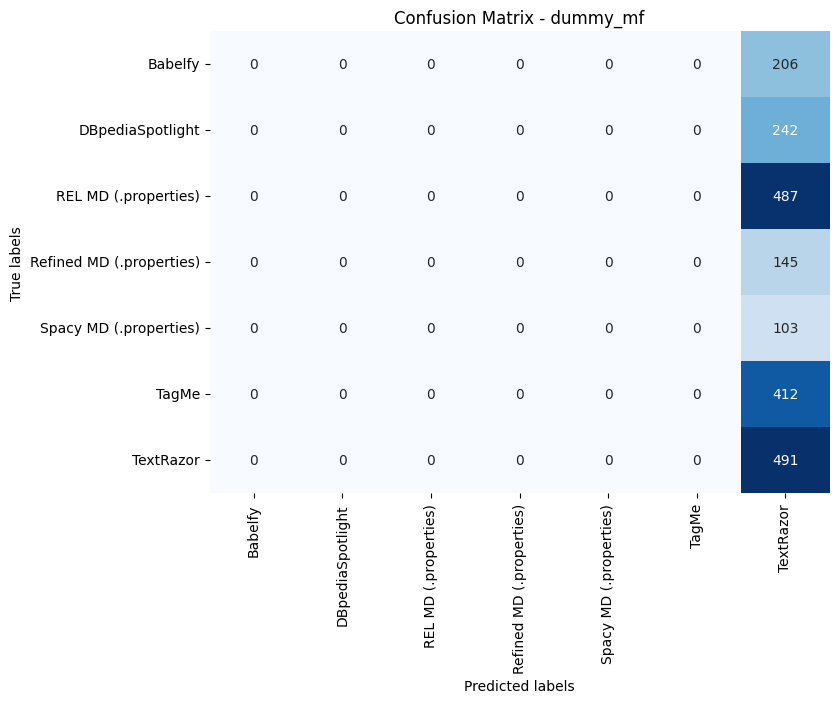

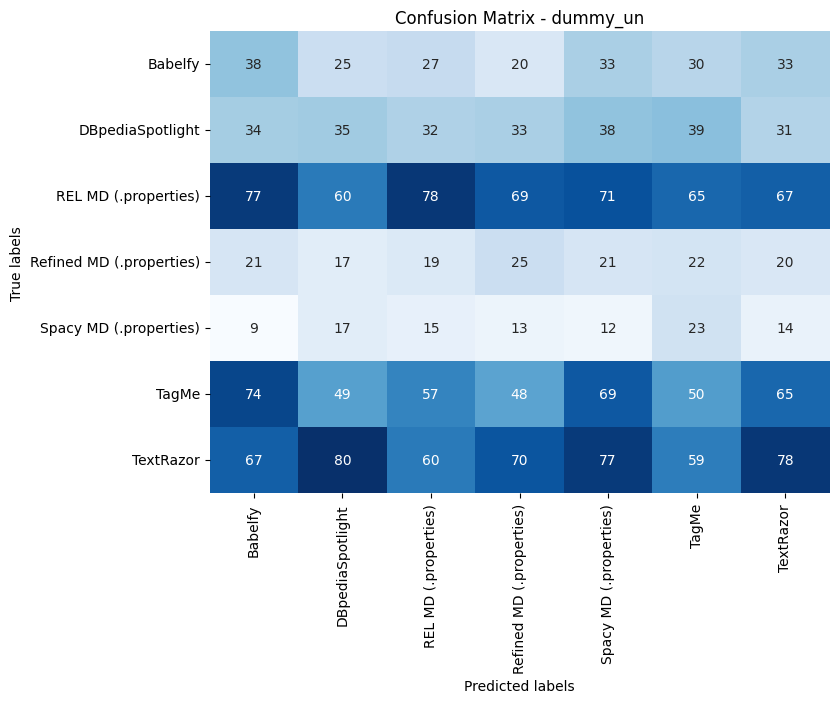

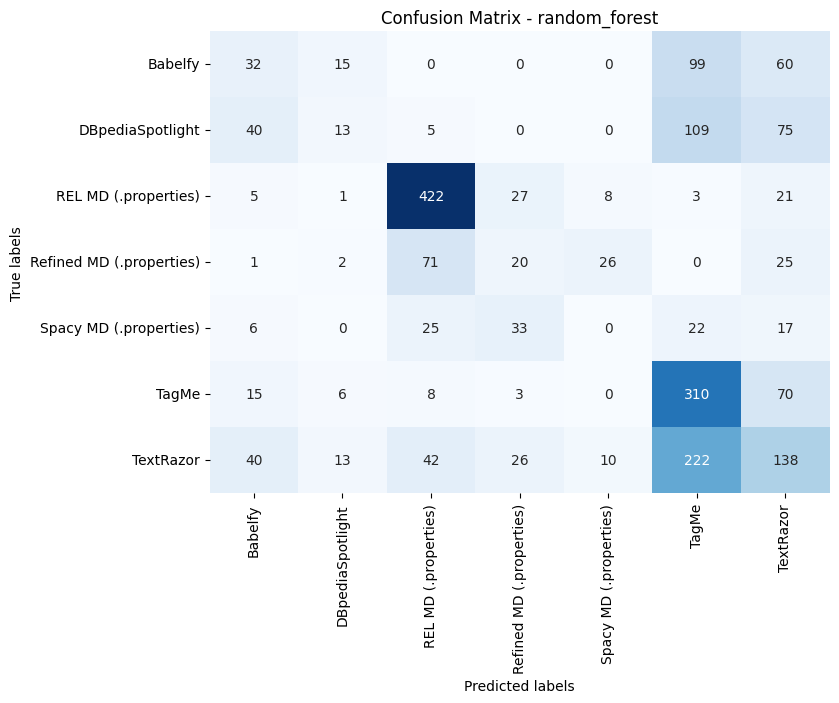

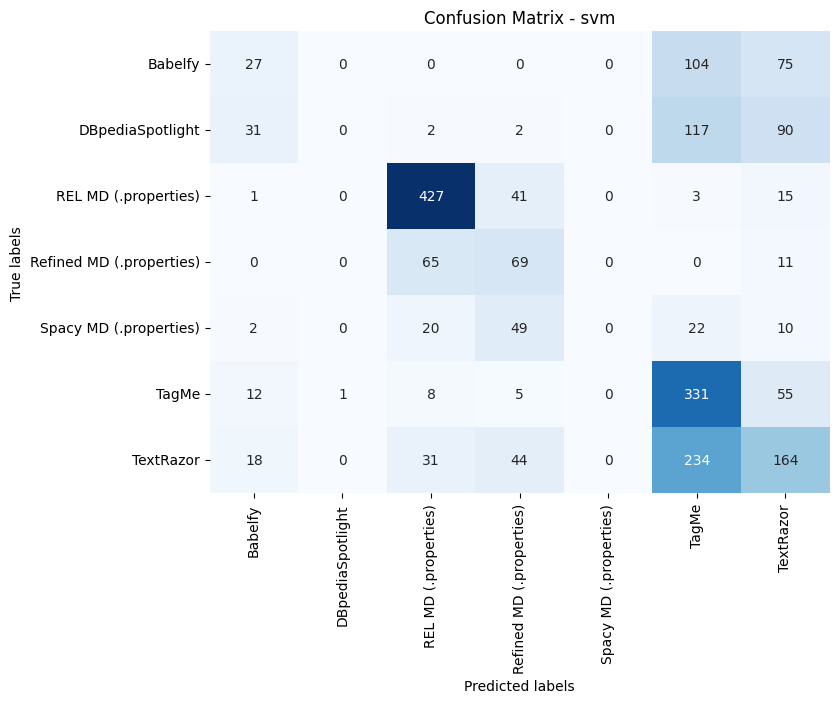

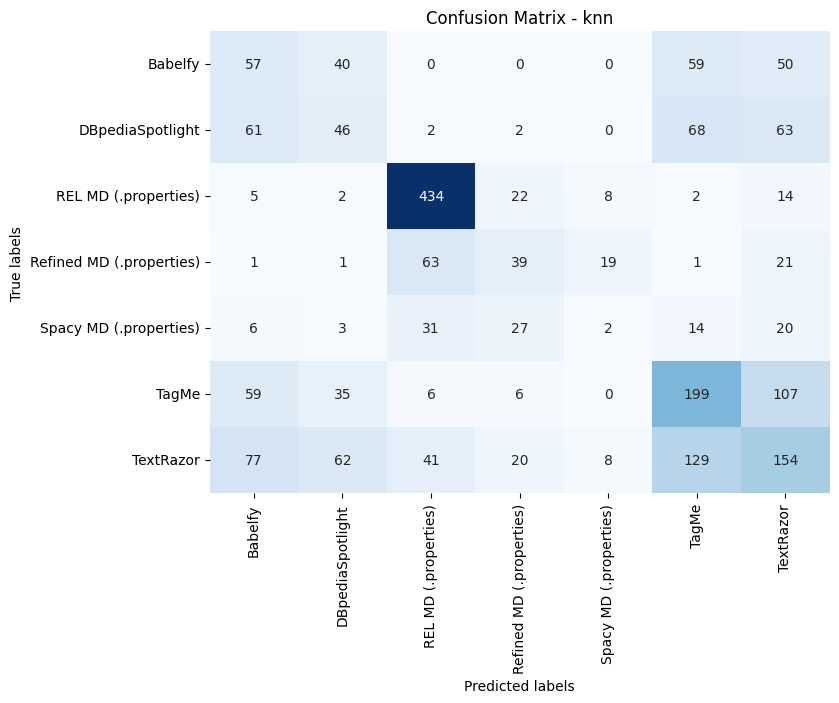

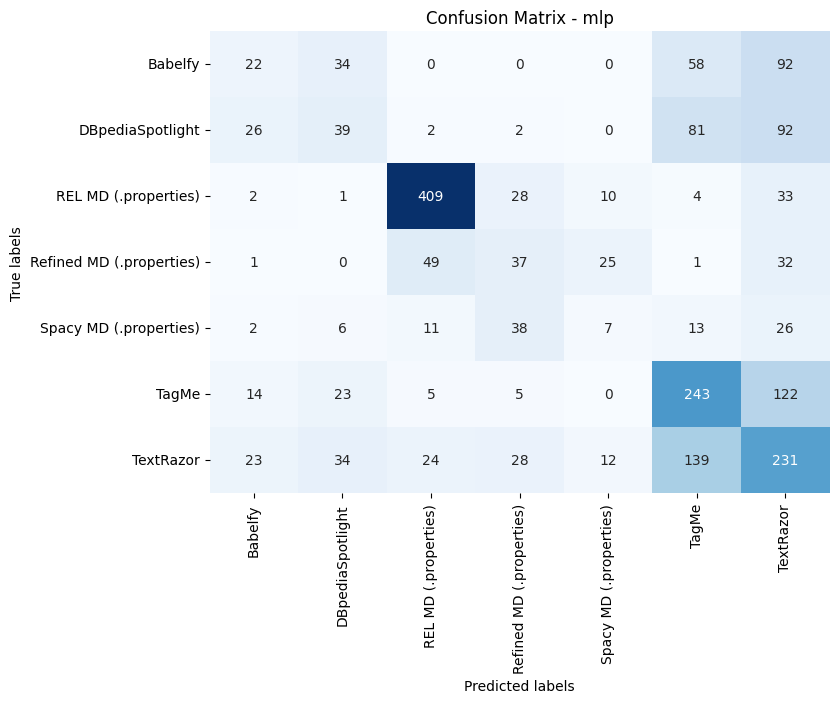

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 10, 'n_estimators': 100}, 'svm': {'C': 1, 'kernel': 'rbf'}, 'knn': {'n_neighbors': 7, 'p': 2}, 'mlp': {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}}
----------------- evaluate: combined topic word emb ---------------------
Training dummy_mf...
Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.1476510067114094, f1 score: 0.1553778254731185, recall: 0.1476510067114094, precision: 0.18139822970681127
random_forest accuracy: 0.45877277085330775, f1 score: 0.42378276508506557, recall: 0.45877277085330775, precision: 0.4271512271169901
svm accuracy: 0.48178331735378715, f1 score: 0.44960953125530784, recall: 0.48178331735378715, precision: 0.45490074943042963
knn accuracy: 0.44439117929050814, f1 score: 0.4299606819823608, recall: 0.44439117929050814, precision: 0.4218545376775405
mlp accuracy: 0.47315436241610737, f1 score: 0.45841843538867155, recall: 0.47315436241610737, precision: 0.45385400240734963


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


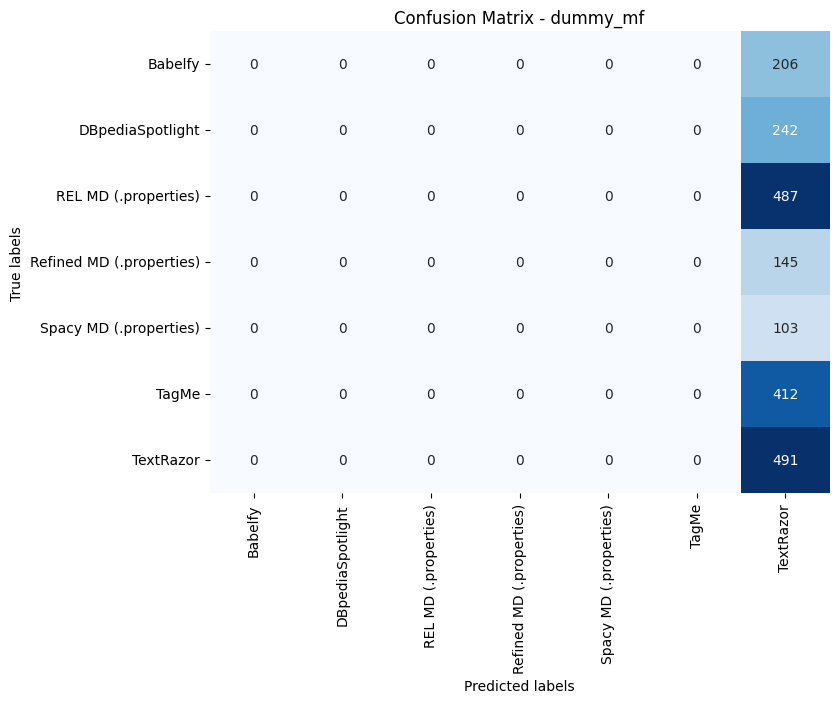

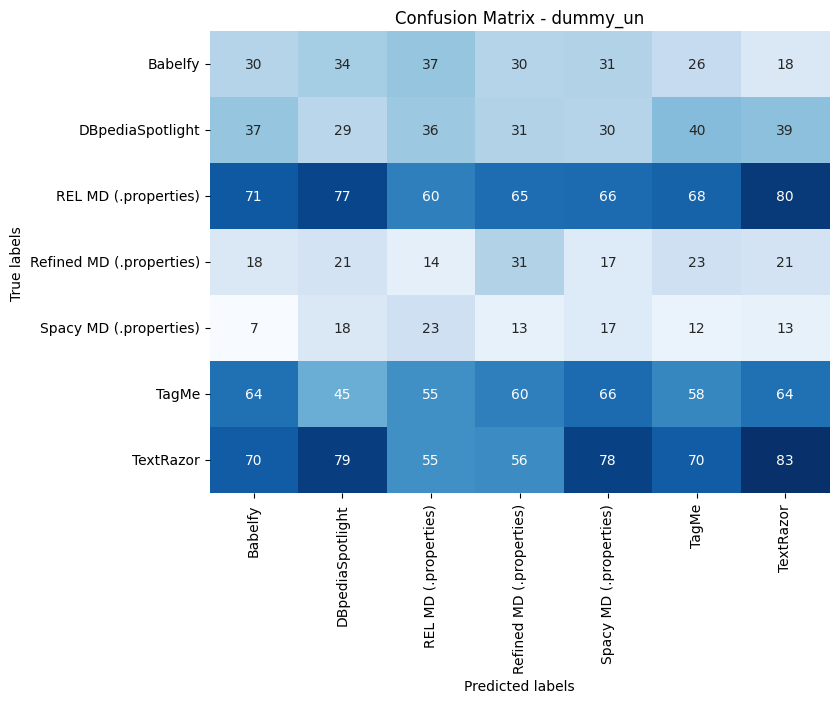

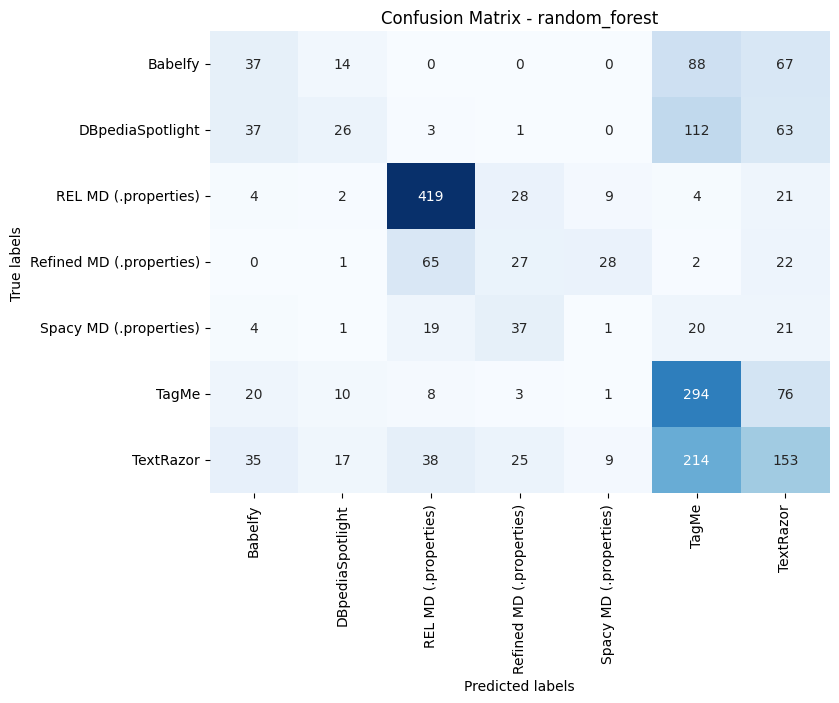

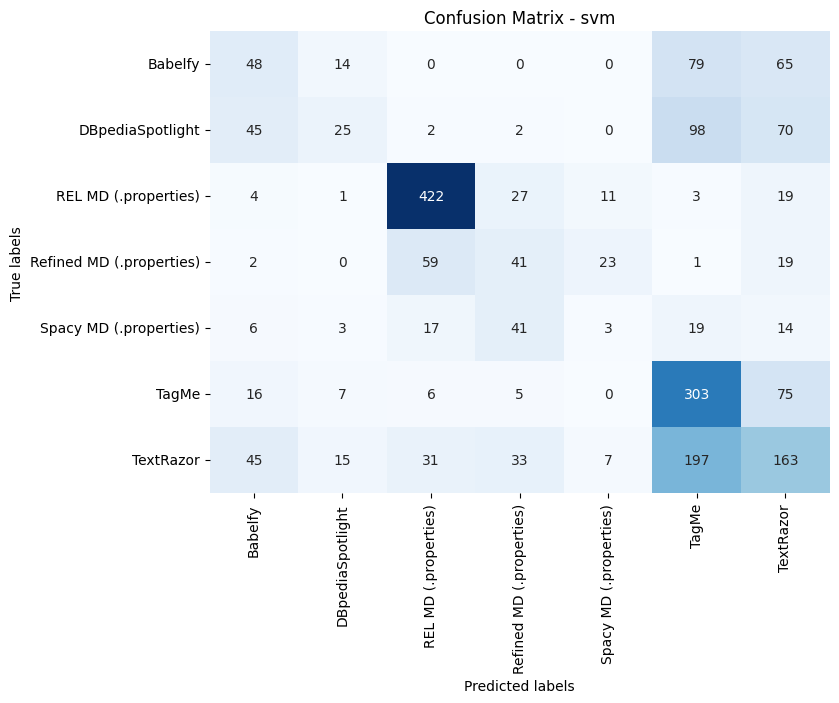

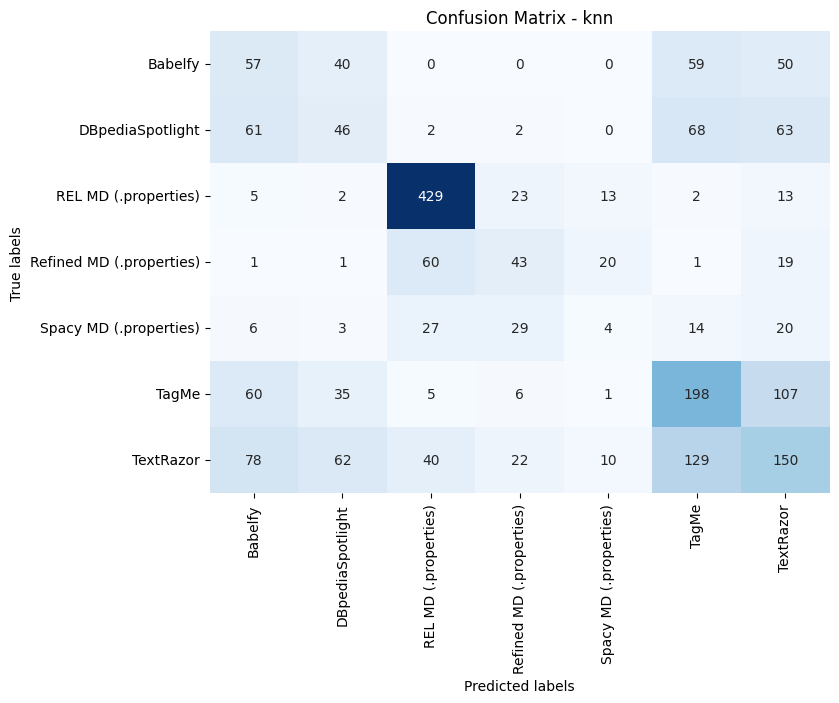

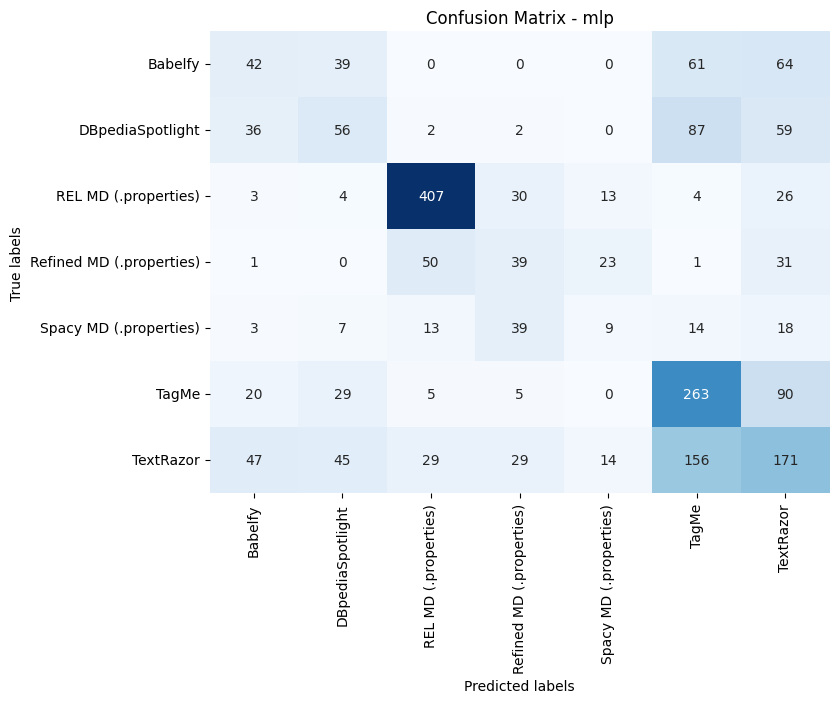

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 20, 'n_estimators': 200}, 'svm': {'C': 0.1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 7, 'p': 2}, 'mlp': {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}}


In [23]:
print("----------------- evaluate: combined one one encoding (noisy) ---------------------")
results_dict['combOneHot'] = evaluate(X_combined_one_hot, y)
print("----------------- evaluate: combined topic word emb ---------------------")
results_dict['combTopcWord'] = evaluate(X_combined_top_word_emb, y)



----------------- evaluate: combined one one encoding (noisy) (PCA) ---------------------
Training dummy_mf...
Training dummy_un...
Training random_forest...


Training svm...
Training knn...
Training mlp...


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.14285714285714285, f1 score: 0.14989013490683178, recall: 0.14285714285714285, precision: 0.17258058240293656
random_forest accuracy: 0.46116970278044106, f1 score: 0.40091045147020865, recall: 0.46116970278044106, precision: 0.42763198975750333
svm accuracy: 0.487535953978907, f1 score: 0.4523882831799276, recall: 0.487535953978907, precision: 0.461419665984904
knn accuracy: 0.44103547459252157, f1 score: 0.42968651682090636, recall: 0.44103547459252157, precision: 0.4282948954432694
mlp accuracy: 0.4827420901246405, f1 score: 0.4642692236684492, recall: 0.4827420901246405, precision: 0.4595159225692693


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


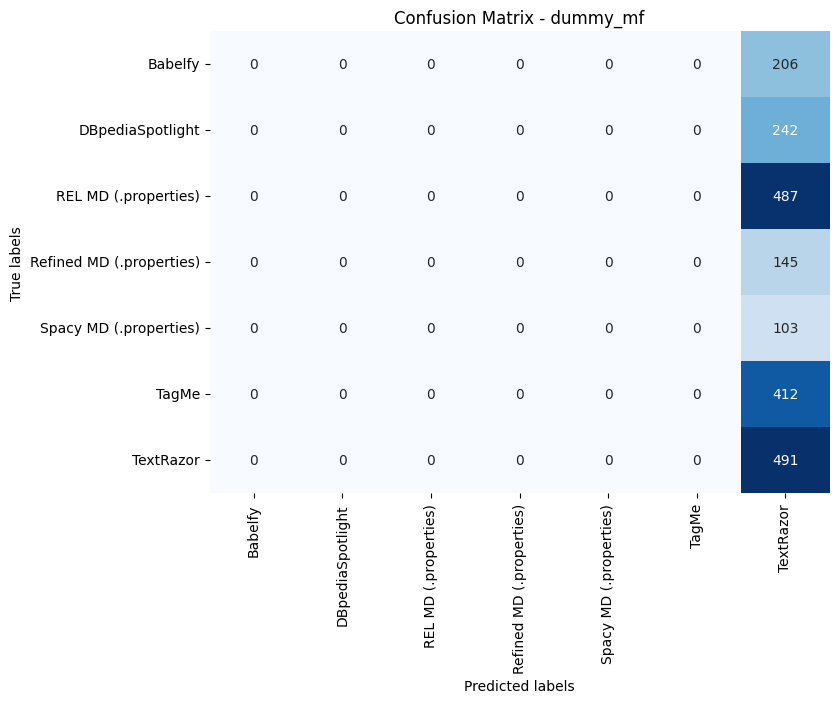

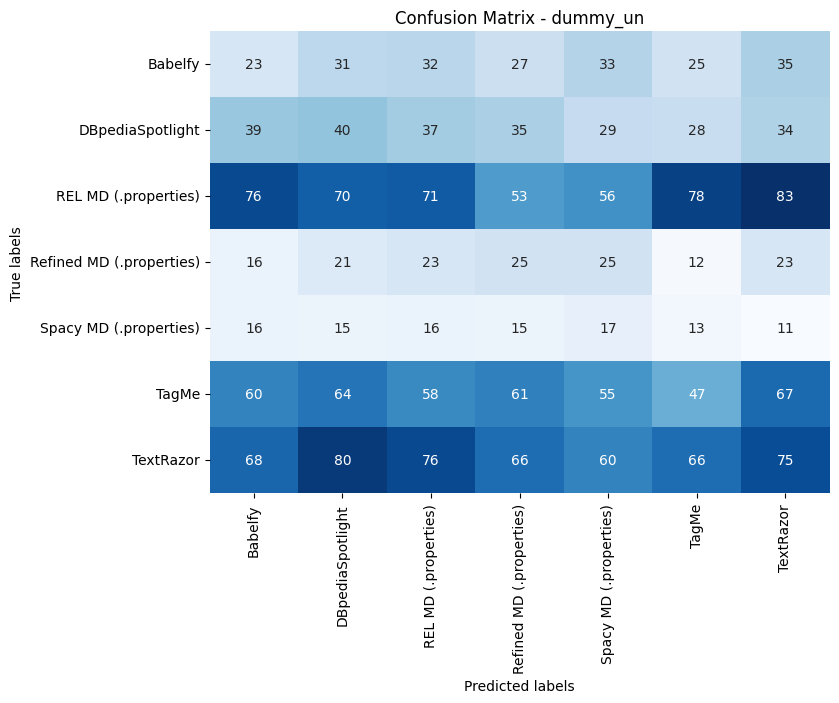

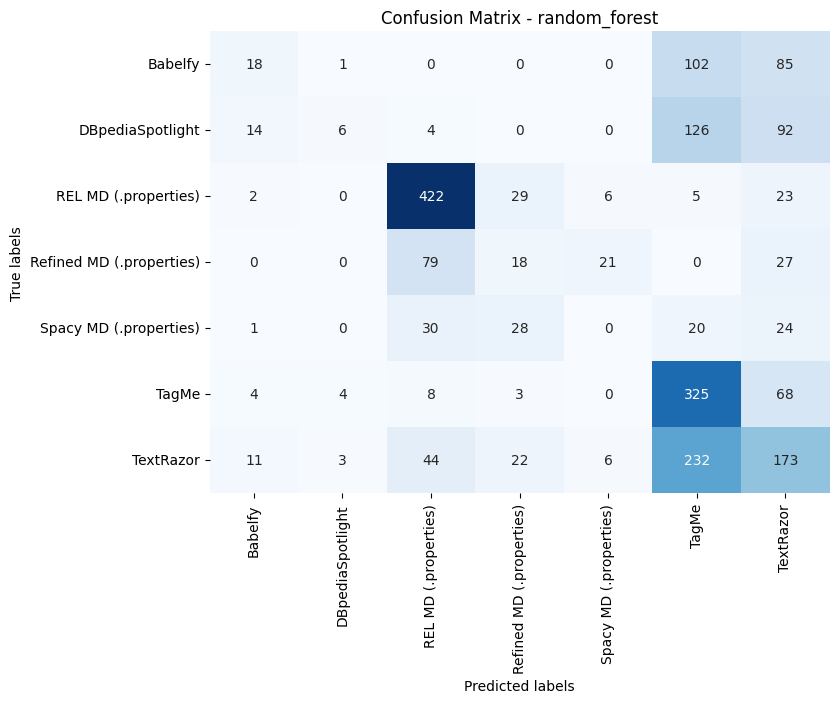

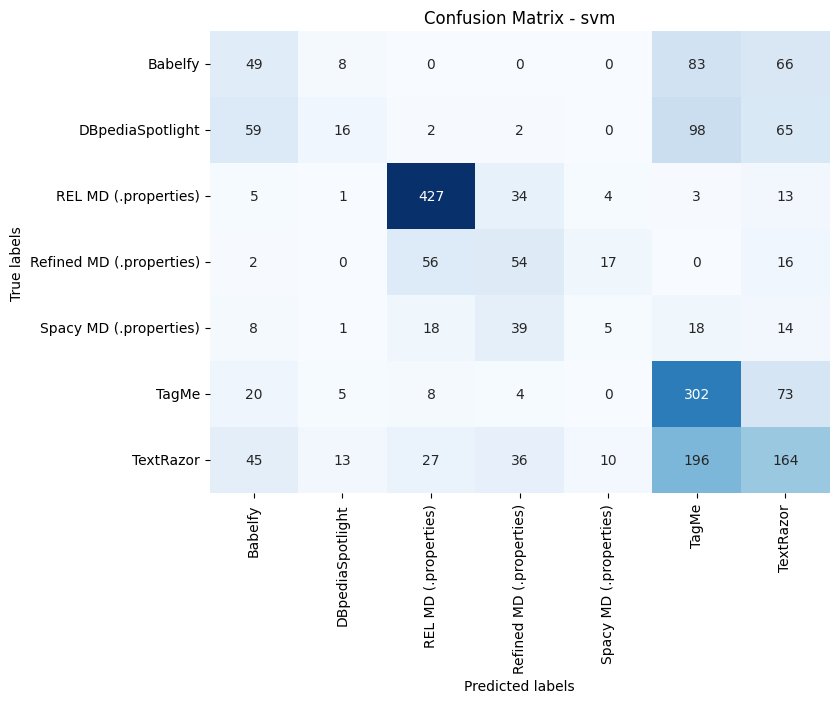

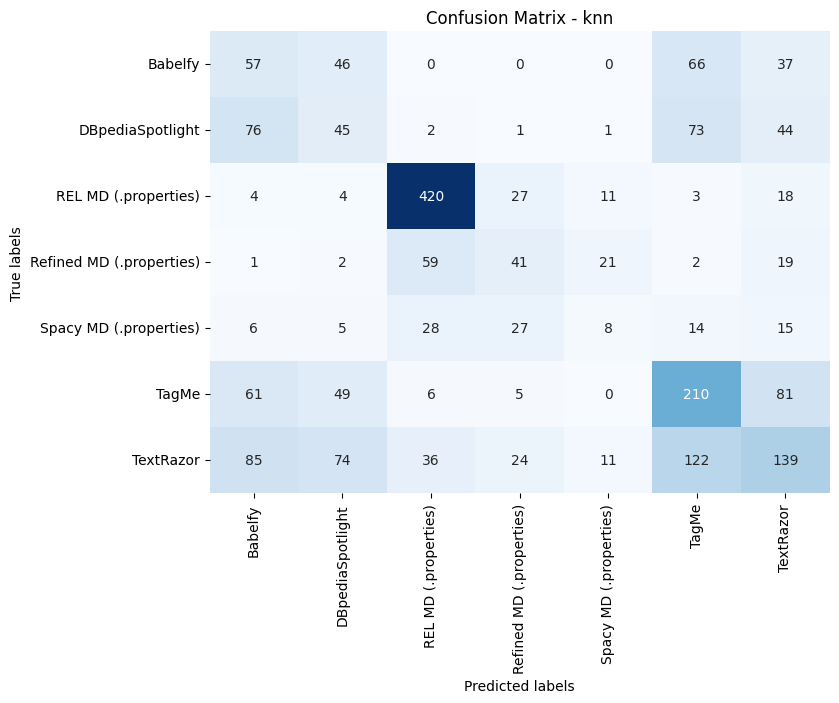

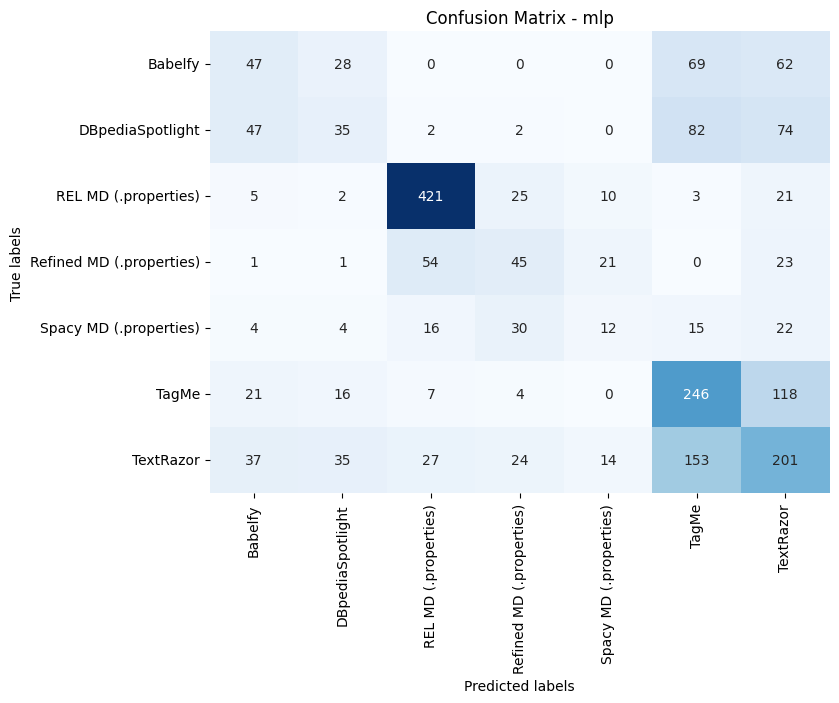

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 10, 'n_estimators': 100}, 'svm': {'C': 0.1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 5, 'p': 1}, 'mlp': {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}}
----------------- evaluate: combined topic word emb (PCA) ---------------------
Training dummy_mf...
Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 

dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.15627996164908917, f1 score: 0.16704538734221677, recall: 0.15627996164908917, precision: 0.19441953779587
random_forest accuracy: 0.4448705656759348, f1 score: 0.3948890288959318, recall: 0.4448705656759348, precision: 0.39946880202928853
svm accuracy: 0.4865771812080537, f1 score: 0.45131747091349683, recall: 0.4865771812080537, precision: 0.46432971150958774
knn accuracy: 0.4434324065196548, f1 score: 0.43249101082243047, recall: 0.4434324065196548, precision: 0.43210222788849595
mlp accuracy: 0.4827420901246405, f1 score: 0.46343580999140493, recall: 0.4827420901246405, precision: 0.4590146813316506


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


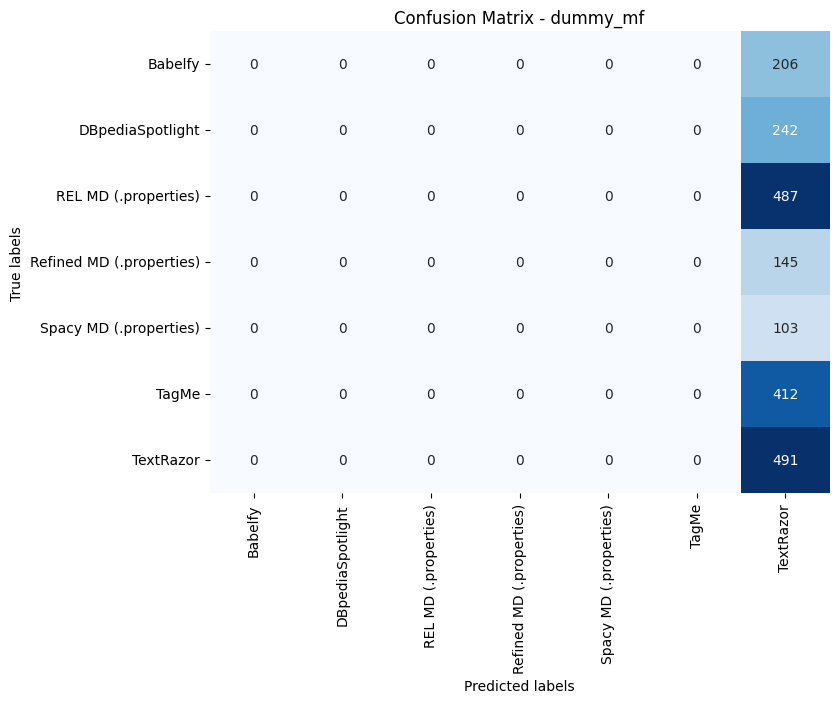

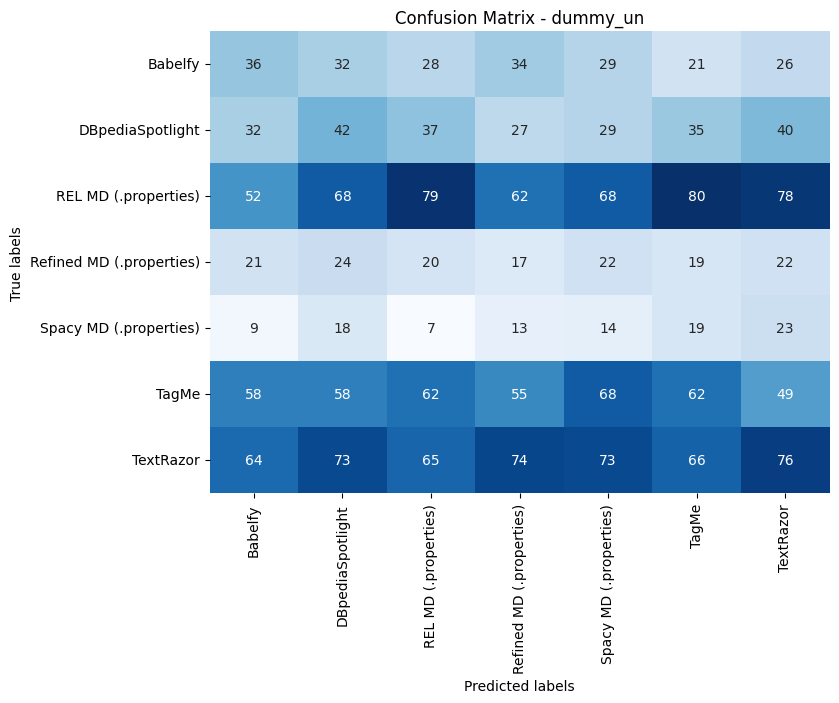

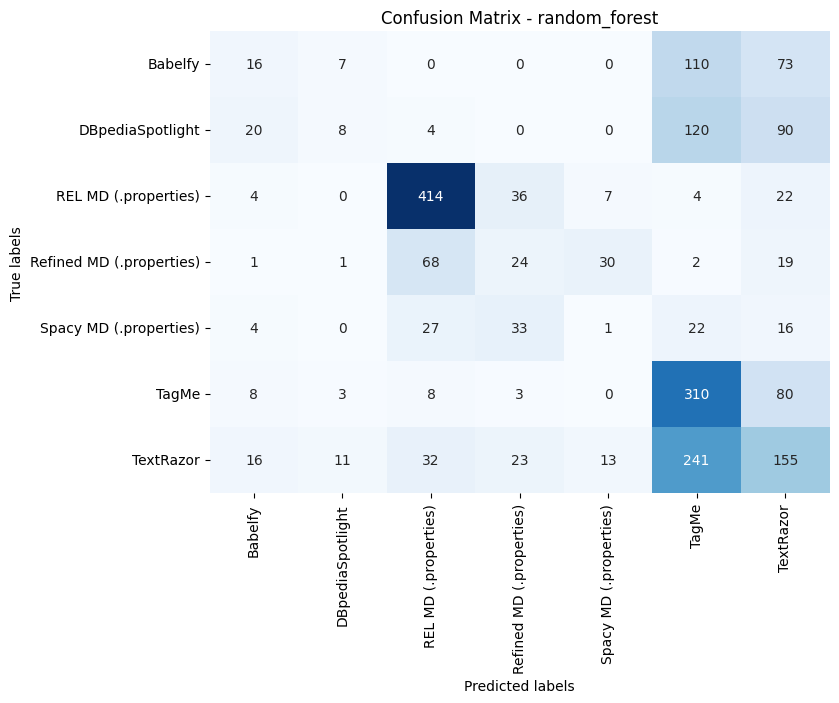

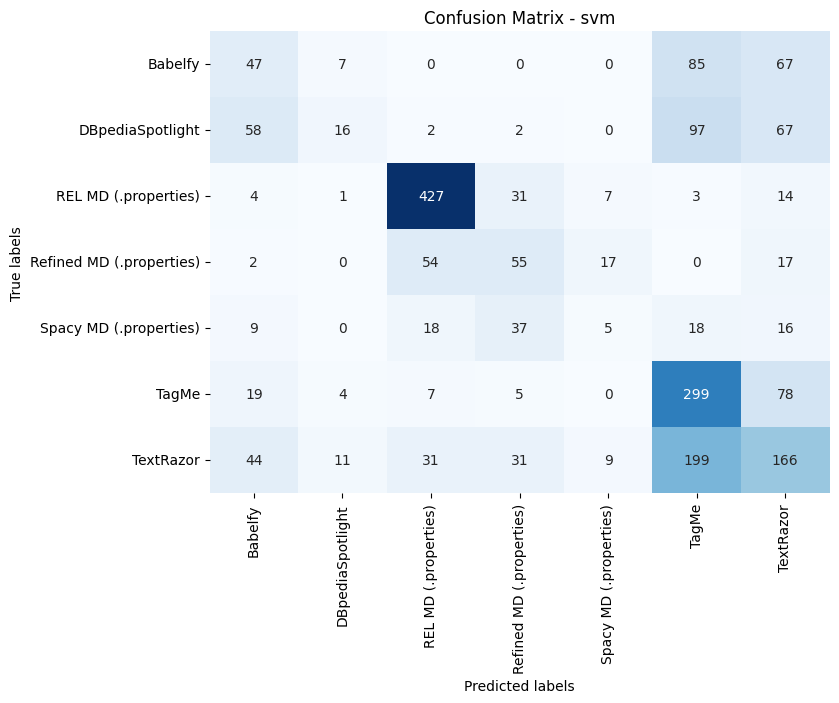

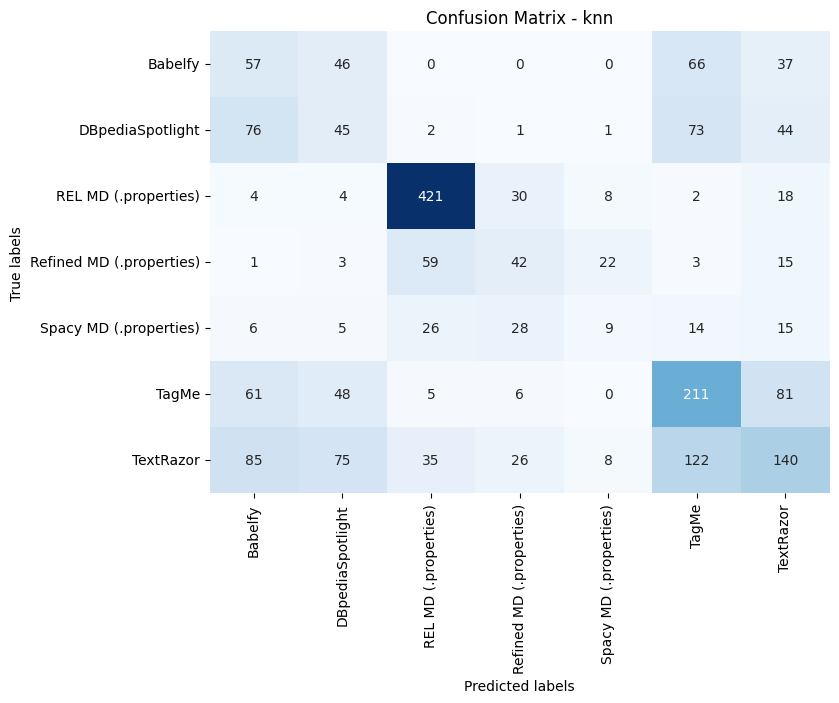

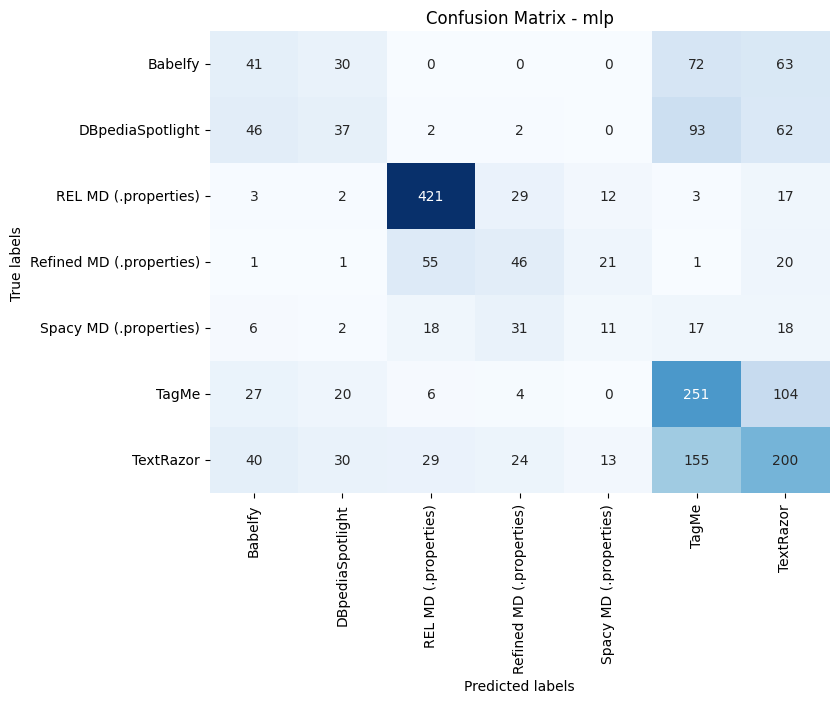

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 10, 'n_estimators': 100}, 'svm': {'C': 0.1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 5, 'p': 1}, 'mlp': {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}}


In [24]:
print("----------------- evaluate: combined one one encoding (noisy) (PCA) ---------------------")
results_dict['oneHotPCA'] = evaluate(X_combined_one_hot_pca, y)
print("----------------- evaluate: combined topic word emb (PCA) ---------------------")
results_dict['topicPCA'] = evaluate(X_combined_top_word_emb_pca, y)


----------------- evaluate:  one encoding (noisy) ---------------------
Training dummy_mf...
Training dummy_un...
Training random_forest...
Training svm...
Training knn...
Training mlp...
dummy_mf accuracy: 0.23537871524448706, f1 score: 0.08969417864574555, recall: 0.23537871524448706, precision: 0.055403139590145326
dummy_un accuracy: 0.1476510067114094, f1 score: 0.15842183068170687, recall: 0.1476510067114094, precision: 0.18858684131677694
random_forest accuracy: 0.4290508149568552, f1 score: 0.32609988986534966, recall: 0.4290508149568552, precision: 0.4143156364963185
svm accuracy: 0.4290508149568552, f1 score: 0.3283881972777535, recall: 0.4290508149568552, precision: 0.418562887471918
knn accuracy: 0.42377756471716205, f1 score: 0.33319005212887504, recall: 0.42377756471716205, precision: 0.3520602670611152
mlp accuracy: 0.4290508149568552, f1 score: 0.3283881972777535, recall: 0.4290508149568552, precision: 0.418562887471918


/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/local/users/unjde/analysis/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

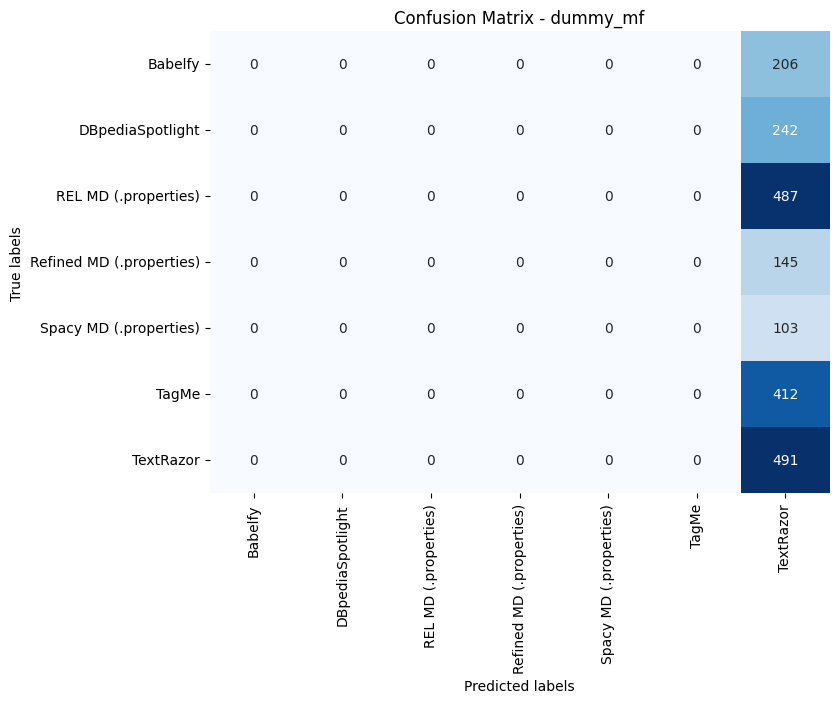

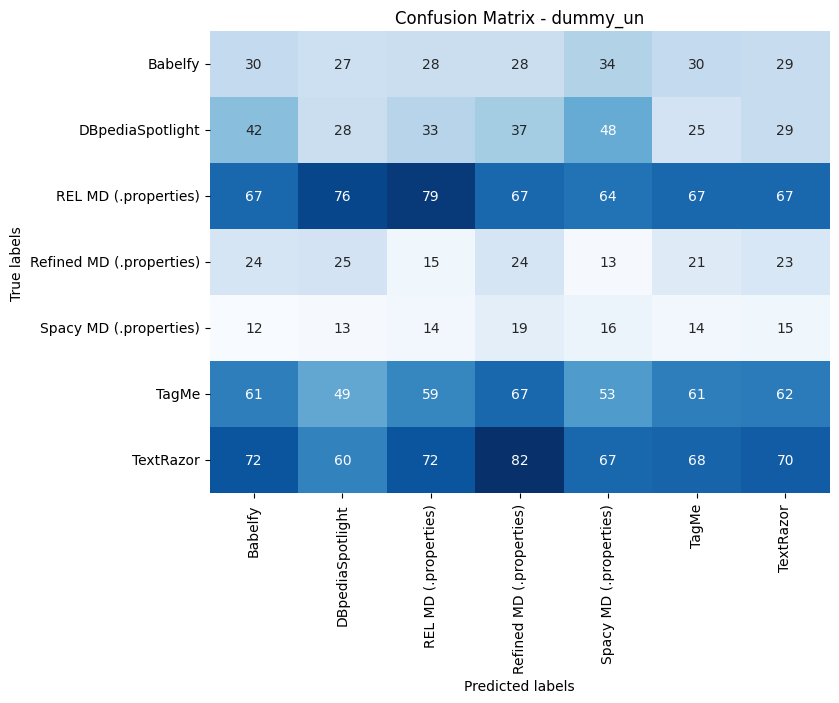

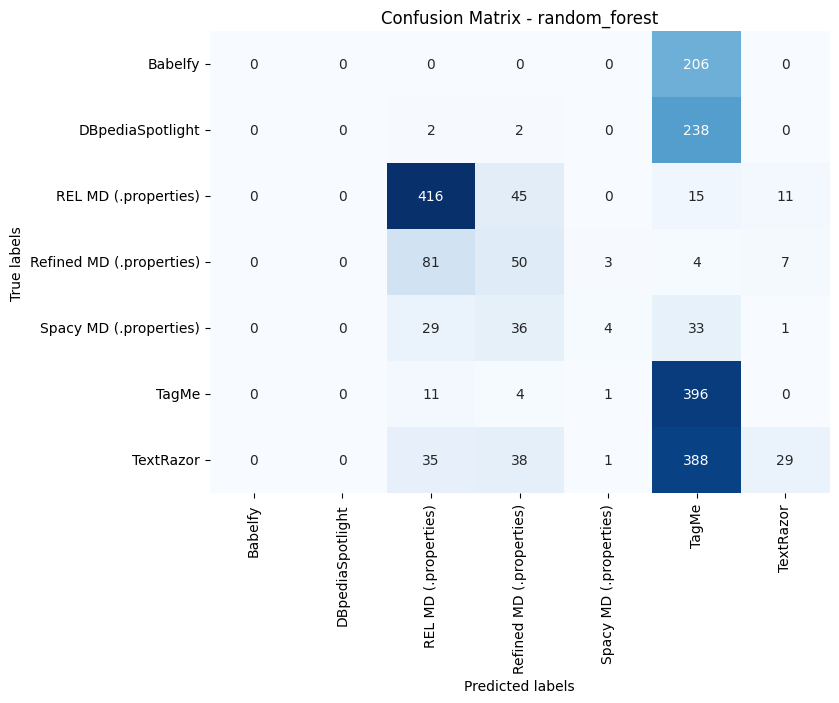

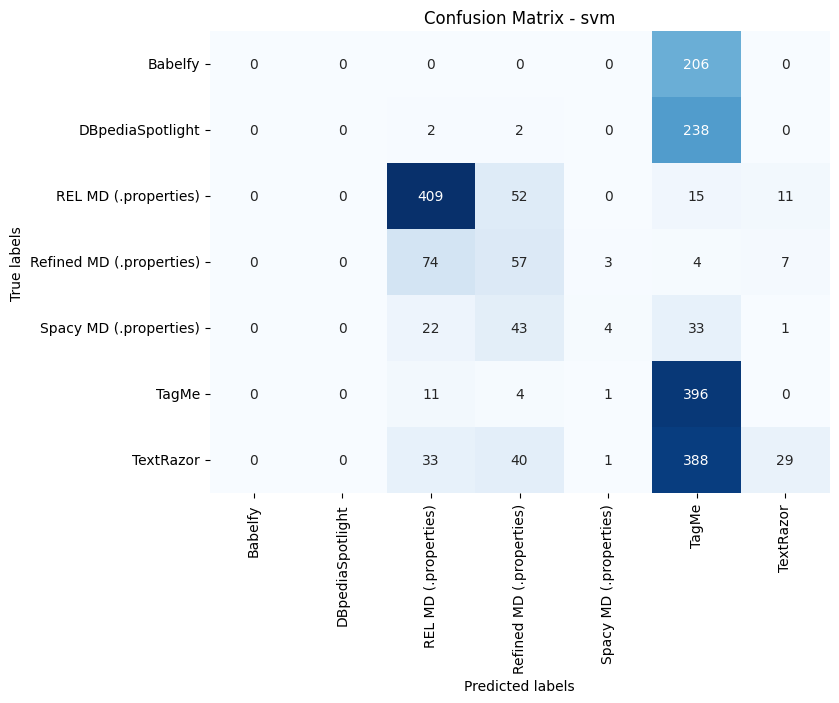

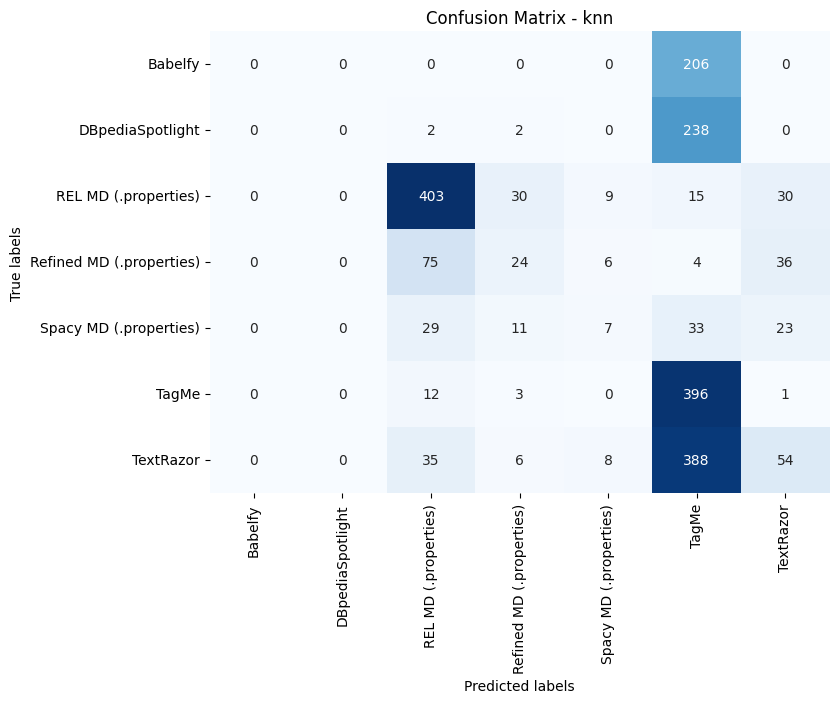

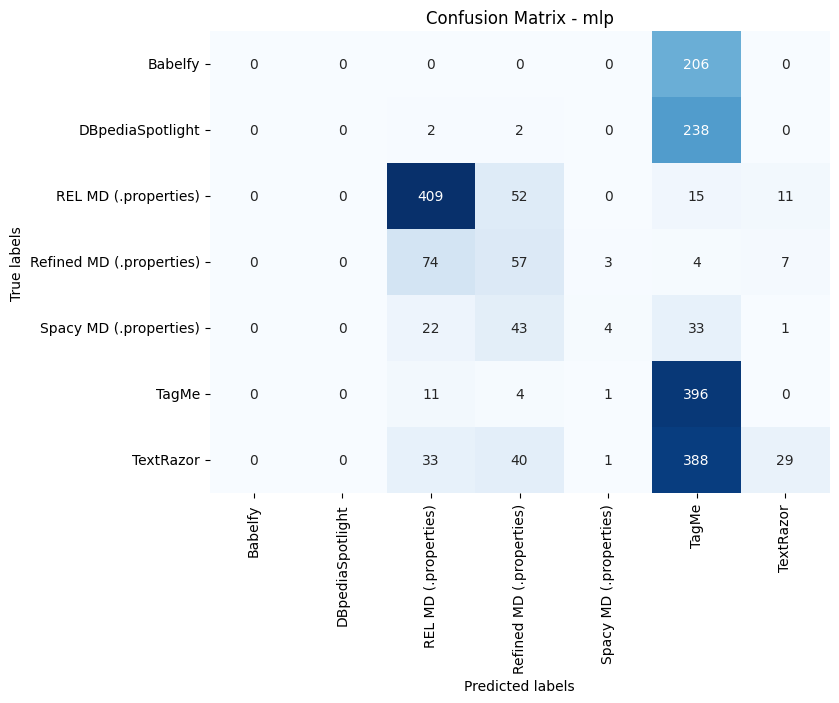

{'dummy_mf': {}, 'dummy_un': {}, 'random_forest': {'max_depth': 30, 'n_estimators': 50}, 'svm': {'C': 1, 'kernel': 'linear'}, 'knn': {'n_neighbors': 7, 'p': 1}, 'mlp': {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'solver': 'adam'}}


In [25]:
print("----------------- evaluate:  one encoding (noisy) ---------------------")
results_dict['oneHotOnly'] = evaluate(X_topics, y)


In [26]:
results_dict

{'docEmbOnly': {'dummy_mf': {'accuracy': 0.23537871524448706,
   'f1': 0.08969417864574555,
   'recall': 0.23537871524448706,
   'precision': 0.055403139590145326},
  'dummy_un': {'accuracy': 0.15148609779482264,
   'f1': 0.16511102725841903,
   'recall': 0.15148609779482264,
   'precision': 0.20001832463569935},
  'random_forest': {'accuracy': 0.45397890699904125,
   'f1': 0.41428128515056195,
   'recall': 0.45397890699904125,
   'precision': 0.41214420077129865},
  'svm': {'accuracy': 0.48801534036433364,
   'f1': 0.4278084416206568,
   'recall': 0.48801534036433364,
   'precision': 0.4030809197922005},
  'knn': {'accuracy': 0.4419942473633749,
   'f1': 0.42771127131750153,
   'recall': 0.4419942473633749,
   'precision': 0.4198554123043881},
  'mlp': {'accuracy': 0.473633748801534,
   'f1': 0.45716624868688,
   'recall': 0.473633748801534,
   'precision': 0.4494866873402737}},
 'combOneHot': {'dummy_mf': {'accuracy': 0.23537871524448706,
   'f1': 0.08969417864574555,
   'recall': 0.

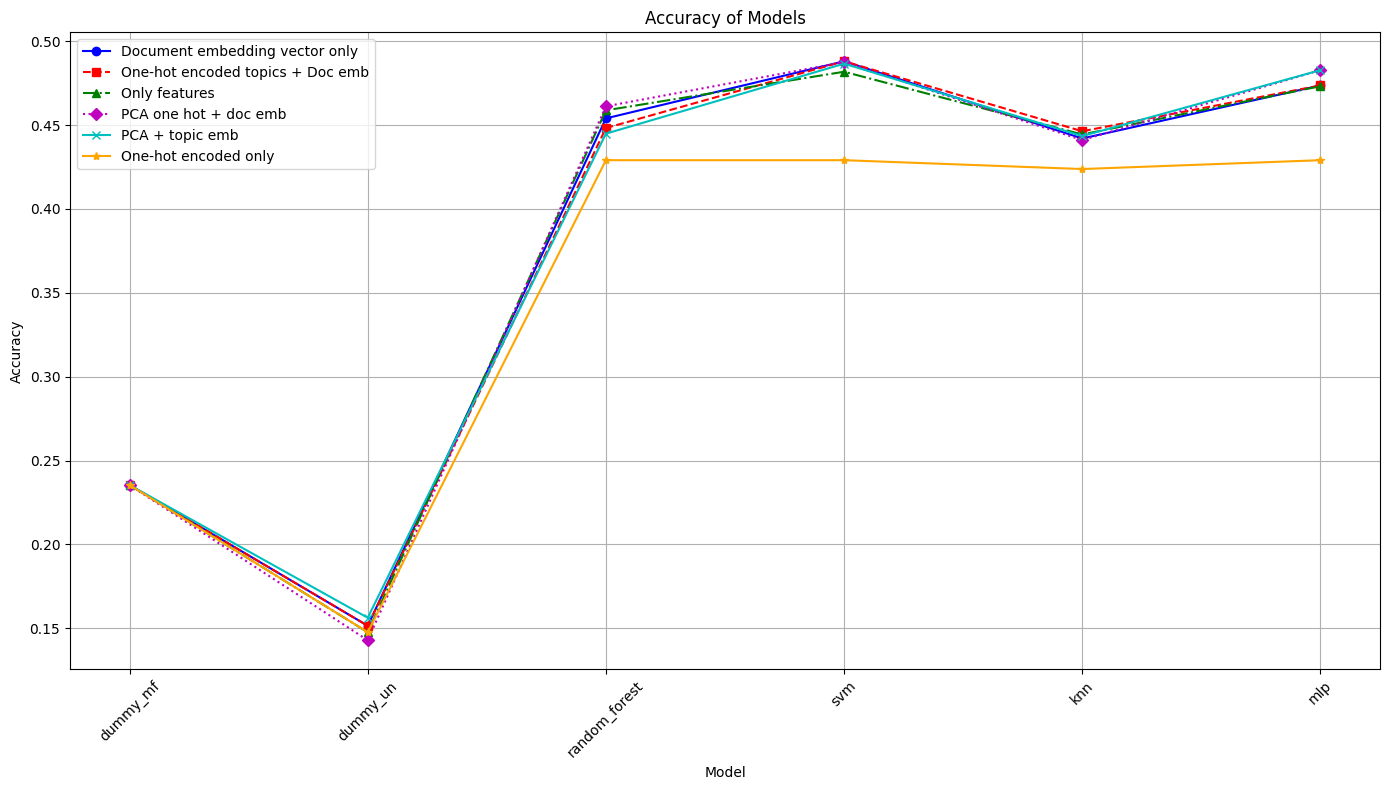

In [27]:

# Extracting model names
models = list(results_dict['docEmbOnly'].keys())

# Extracting accuracies for each method
accuracy_doc_emb = [results_dict['docEmbOnly'][model]['accuracy'] for model in models]
accuracy_one_hot = [results_dict['combOneHot'][model]['accuracy'] for model in models]
accuracy_only_features = [results_dict['combTopcWord'][model]['accuracy'] for model in models]
accuracy_pca_one_hot_doc_emb = [results_dict['oneHotPCA'][model]['accuracy'] for model in models]
accuracy_pca_topic_emb = [results_dict['topicPCA'][model]['accuracy'] for model in models]
accuracy_one_hot_only = [results_dict['oneHotOnly'][model]['accuracy'] for model in models]

# Plotting Accuracy
plt.figure(figsize=(14, 8))
plt.plot(models, accuracy_doc_emb, marker='o', color='b', linestyle='-', label='Document embedding vector only')
plt.plot(models, accuracy_one_hot, marker='s', color='r', linestyle='--', label='One-hot encoded topics + Doc emb')
plt.plot(models, accuracy_only_features, marker='^', color='g', linestyle='-.', label='Only features')
plt.plot(models, accuracy_pca_one_hot_doc_emb, marker='D', color='m', linestyle=':', label='PCA one hot + doc emb')
plt.plot(models, accuracy_pca_topic_emb, marker='x', color='c', linestyle='-', label='PCA + topic emb')
plt.plot(models, accuracy_one_hot_only, marker='*', color='orange', linestyle='-', label='One-hot encoded only')
plt.xticks(rotation=45)
plt.title('Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

In [28]:
results_dict

{'docEmbOnly': {'dummy_mf': {'accuracy': 0.23537871524448706,
   'f1': 0.08969417864574555,
   'recall': 0.23537871524448706,
   'precision': 0.055403139590145326},
  'dummy_un': {'accuracy': 0.15148609779482264,
   'f1': 0.16511102725841903,
   'recall': 0.15148609779482264,
   'precision': 0.20001832463569935},
  'random_forest': {'accuracy': 0.45397890699904125,
   'f1': 0.41428128515056195,
   'recall': 0.45397890699904125,
   'precision': 0.41214420077129865},
  'svm': {'accuracy': 0.48801534036433364,
   'f1': 0.4278084416206568,
   'recall': 0.48801534036433364,
   'precision': 0.4030809197922005},
  'knn': {'accuracy': 0.4419942473633749,
   'f1': 0.42771127131750153,
   'recall': 0.4419942473633749,
   'precision': 0.4198554123043881},
  'mlp': {'accuracy': 0.473633748801534,
   'f1': 0.45716624868688,
   'recall': 0.473633748801534,
   'precision': 0.4494866873402737}},
 'combOneHot': {'dummy_mf': {'accuracy': 0.23537871524448706,
   'f1': 0.08969417864574555,
   'recall': 0.

In [14]:
ds_doc = {}
for ds in raw_text_labels_files:
    ds_doc[ds['ds']] = []
    for key, value in ds['raw'].items():
        ds_doc[ds['ds']].append(value['doc'])


In [15]:
ds_doc['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']

['Allen founded the EMP in Seattle, which featured exhibitions about Hendrix and Dylan, but also about various science fiction movies.',
 'City won 3:2 against the Spurs.',
 'Atletico has beaten its archrival Real.',
 'Thomas and Mario are strikers playing in Munich.',
 'Karl and Theo made their extreme fortunes selling low-price groceries.',
 'The Sun and The Times reported that Greece will have to leave the Euro soon.',
 'Tiger lost the US Open.',
 'Three of the greatest guitarists started their career in a single band : Clapton, Beck, and Page.',
 'Angelina, her father Jon, and her partner Brad never played together in the same movie.',
 'Justin, Stefani, and Kate are among the most popular people on both MTV and Twitter.',
 'Dylan performed Hurricane about the black fighter Carter, from his album Desire.',
 'The Enola Gay bombed Hiroshima at the end of Second World War.\ufeff',
 'David and Victoria added spice to their marriage.',
 'Jobs and Baez dated in the late 1970s, and she pe

In [16]:
def get_doc_id(text):
    for idx, doc in enumerate(doc_values):
        if doc == text:
            return idx
    return -1


In [17]:
get_doc_id(ds_doc['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl'][0])

0

In [18]:
topic_model.hierarchical_topic_reduction(num_topics=10)

[[0],
 [8, 17, 22, 31, 1],
 [18, 34, 23, 7, 32, 19, 33, 6],
 [11, 12, 3],
 [2],
 [5, 26, 27, 21],
 [16, 15, 4],
 [24, 9],
 [28, 10, 29, 30, 20],
 [14, 25, 13]]

In [19]:
get_doc_id("Allen founded the EMP in Seattle, which featured exhibitions about Hendrix and Dylan, but also about various science fiction movies.")

0

In [20]:
ds_doc_topics = {}
not_treated = 0
for ds_name, list_docs in ds_doc.items():
    ds_doc_topics[ds_name] = {}
    ds_doc_topics[ds_name]['doc'] = []
    for doc in list_docs:
        if get_doc_id(doc) == -1:
            not_treated += 1
            continue
        document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[get_doc_id(doc)],reduced=True, num_topics=432897)
        ds_doc_topics[ds_name]['doc'].append({
            'text': doc,
            'topics': document_topics,
            'scores': scores
        })


In [21]:
ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/medmention/corpus_pubtator.json']

{'doc': [{'text': 'DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis. Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been includ

In [22]:
print(scores)

[[ 0.6029424   0.28571033  0.19492236  0.17559361  0.16373225  0.16313358
   0.1235427   0.09845725  0.00474329 -0.0160108 ]]


In [23]:
for key, value in ds_doc_topics.items():
    topic_totals = {}
    topic_counts = {}

    value = value['doc']
    for sample in value:
        topics = sample['topics'][0]
        scores = sample['scores'][0]
        
        for topic, score in zip(topics, scores):
            if topic in topic_totals:
                topic_totals[topic] += score
                topic_counts[topic] += 1
            else:
                topic_totals[topic] = score
                topic_counts[topic] = 1

    topic_averages = {topic: topic_totals[topic] / topic_counts[topic] for topic in topic_totals}

    sorted_topics_total = sorted(topic_totals.items(), key=lambda item: item[1], reverse=True)
    sorted_topics_avg = sorted(topic_averages.items(), key=lambda item: item[1], reverse=True)
    ds_doc_topics[key]['topics'] = [f for f, _ in sorted_topics_total]
    ds_doc_topics[key]['avgs'] = [s for _, s in sorted_topics_avg]

In [24]:
ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/medmention/corpus_pubtator.json']['avgs']

[0.5909012257574019,
 0.28540448111515954,
 0.24125783805155496,
 0.22124255138552187,
 0.1684643016760027,
 0.16832416036245554,
 0.15897492484704928,
 0.11960404111290021,
 0.07457819481850327,
 0.04543848149350184]

In [26]:

print(ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']['topics'])
print(ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']['avgs'])

[9, 5, 7, 2, 4, 6, 1, 8, 3, 0]
[0.2575269317626953, 0.21274887084960936, 0.1696397590637207, 0.14252413749694826, 0.13286991119384767, 0.11603943824768066, 0.10372918128967284, 0.08504384994506836, 0.057384033203125, 0.015537397861480713]


In [274]:

print(ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/medmention/corpus_pubtator.json']['topics'])
print(ds_doc_topics['/local/users/unjde/analysis/analysis/analysis/combining_linking_techniques_analysis/data/datasets/medmention/corpus_pubtator.json']['avgs'])

[0, 3, 1, 6, 8, 7, 2, 4, 9, 5]
[0.5909012257574019, 0.28540448111515954, 0.24125783805155496, 0.22124255138552187, 0.1684643016760027, 0.16832416036245554, 0.15897492484704928, 0.11960404111290021, 0.07457819481850327, 0.04543848149350184]


In [31]:
topic_model.get_topics(num_topics=10)[0][7]

array(['wickets overs', 'wickets', 'waqar younis', 'five wickets',
       'wickets bowling', 'cricket england', 'wickets bat', 'wasim akram',
       'cricket pakistan', 'fall wickets', 'nine wickets',
       'overs cricket', 'cricket match', 'cricket australia',
       'england pakistan', 'first innings', 'cricket english', 'innings',
       'overs match', 'championship cricket', 'mohammad akram',
       'overs sri', 'second innings', 'pakistan beat', 'innings runs',
       'test series', 'cricket', 'khan pakistan', 'west indies',
       'saeed anwar', 'aamir sohail', 'lanka', 'pakistan oval',
       'hits innings', 'match australia', 'england captain', 'sri lankan',
       'seven innings', 'pakistan', 'overs', 'scoreless innings',
       'sri lanka', 'asif mujtaba', 'england beat', 'eight innings',
       'australia beat', 'inzamam ul', 'qualifying match', 'ian healy',
       'fall wicket'], dtype='<U27')

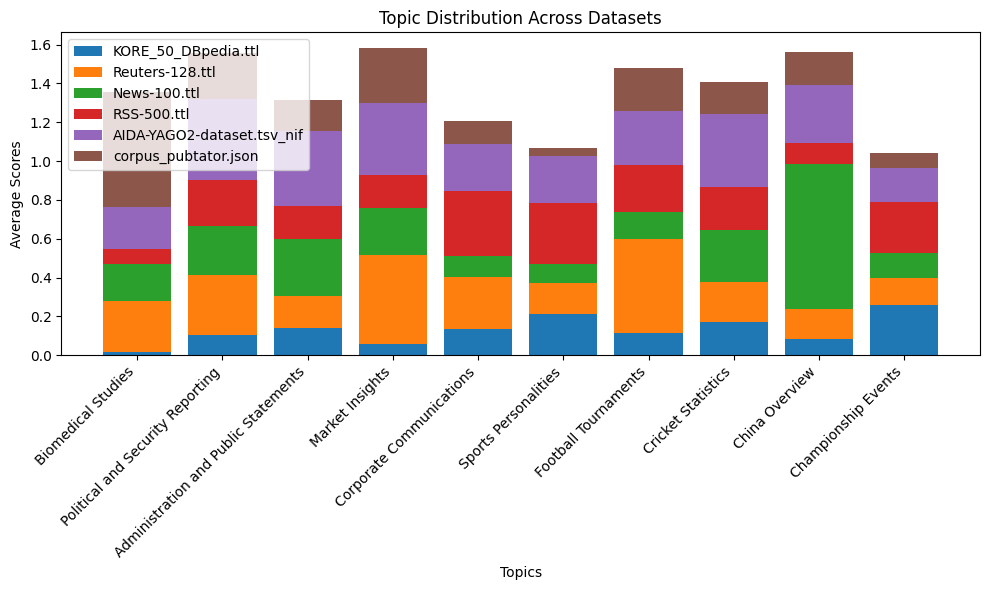

In [276]:

topics = ['Biomedical Studies', 'Political and Security Reporting', 'Administration and Public Statements', 'Market Insights', 'Corporate Communications', 'Sports Personalities', 'Football Tournaments', 'Cricket Statistics', 'China Overview', 'Championship Events']

avgs_matrix = np.zeros((len(ds_doc_topics), len(topics)))

for i, (label, data) in enumerate(ds_doc_topics.items()):
    for j, topic_index in enumerate(data['topics']):
        avgs_matrix[i, topic_index] = data['avgs'][j]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.8
bottoms = np.zeros(len(topics))  

for i, (label, data) in enumerate(ds_doc_topics.items()):
    ax.bar(topics, avgs_matrix[i], bar_width, label=label.split('/')[-1], bottom=bottoms)
    bottoms += avgs_matrix[i]  

ax.set_xlabel('Topics')
ax.set_ylabel('Average Scores')
ax.set_title('Topic Distribution Across Datasets')
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# NORMALIZE??? each bar adds up to 1


In [303]:
ds_doc_topics = {}
not_treated = 0
for ds in raw_text_labels_files:
    ds = ds['raw']
    for key, doc_dict in ds.items():
        doc = doc_dict['doc']
        if get_doc_id(doc) == -1:
            not_treated += 1
            continue
        document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[get_doc_id(doc)],reduced=True, num_topics=432897)
        systems = [label['system'] for label in doc_dict['label']]
        for s in systems:
            if s not in ds_doc_topics:
                ds_doc_topics[s] = {}
                ds_doc_topics[s]['doc'] = []
            ds_doc_topics[s]['doc'].append({
                'text': doc,
                'topics': document_topics,
                'scores': scores
            })





In [306]:
ds_doc_topics['Babelfy']

{'doc': [{'text': 'The Relationship Between Distance and Post-operative Visit Attendance Following Medical Male Circumcision in Nyanza Province, Kenya. To date, there is no research on voluntary medical male circumcision (VMMC) catchment areas or the relationship between distance to a VMMC facility and attendance at a post-operative follow-up visit. We analyzed data from a randomly selected subset of males self-seeking circumcision at one of 16 participating facilities in Nyanza Province, Kenya between 2008 and 2010. Among 1437 participants, 46.7 % attended follow-up. The median distance from residence to utilized facility was 2.98 km (IQR 1.31-5.38). Nearly all participants (98.8 %) lived within 5 km from a facility, however, 26.3 % visited a facility more than 5 km away. Stratified results demonstrated that among those utilizing fixed facilities, greater distance was associated with higher odds of follow-up non-attendance (OR 5.01-10km vs. 0-1km = 1.71, 95 % CI 1.08, 2.70, p = 0.02; 

In [305]:
for key, value in ds_doc_topics.items():
    topic_totals = {}
    topic_counts = {}

    value = value['doc']
    for sample in value:
        topics = sample['topics'][0]
        scores = sample['scores'][0]
        
        for topic, score in zip(topics, scores):
            if topic in topic_totals:
                topic_totals[topic] += score
                topic_counts[topic] += 1
            else:
                topic_totals[topic] = score
                topic_counts[topic] = 1

    topic_averages = {topic: topic_totals[topic] / topic_counts[topic] for topic in topic_totals}

    sorted_topics_total = sorted(topic_totals.items(), key=lambda item: item[1], reverse=True)
    sorted_topics_avg = sorted(topic_averages.items(), key=lambda item: item[1], reverse=True)
    ds_doc_topics[key]['topics'] = [f for f, _ in sorted_topics_total]
    ds_doc_topics[key]['avgs'] = [s for _, s in sorted_topics_avg]


In [298]:
not_treated

47

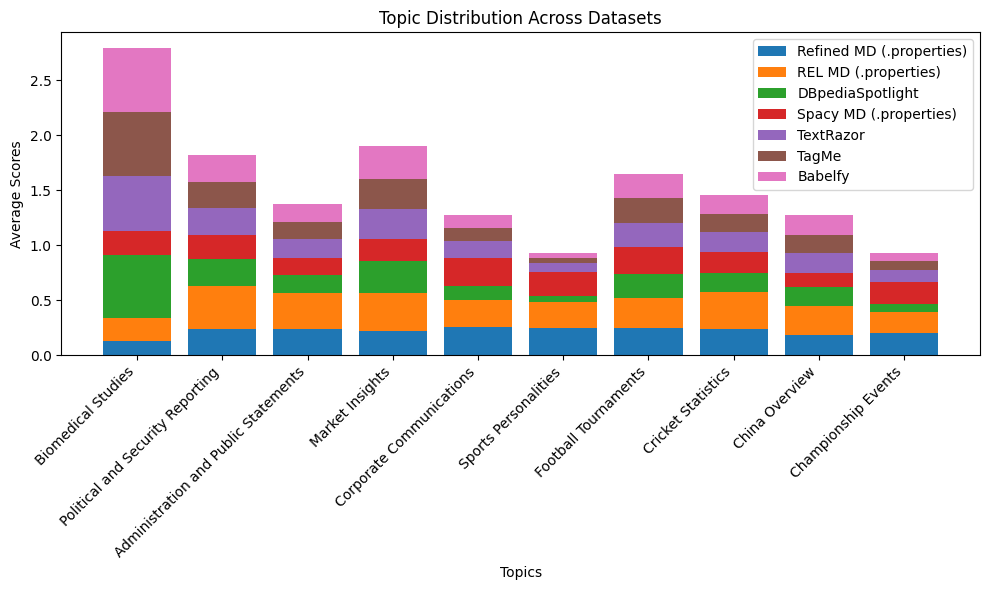

In [307]:

topics = ['Biomedical Studies', 'Political and Security Reporting', 'Administration and Public Statements', 'Market Insights', 'Corporate Communications', 'Sports Personalities', 'Football Tournaments', 'Cricket Statistics', 'China Overview', 'Championship Events']

avgs_matrix = np.zeros((len(ds_doc_topics), len(topics)))

for i, (label, data) in enumerate(ds_doc_topics.items()):
    for j, topic_index in enumerate(data['topics']):
        avgs_matrix[i, topic_index] = data['avgs'][j]

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.8
bottoms = np.zeros(len(topics))  

for i, (label, data) in enumerate(ds_doc_topics.items()):
    ax.bar(topics, avgs_matrix[i], bar_width, label=label.split('/')[-1], bottom=bottoms)
    bottoms += avgs_matrix[i]  

ax.set_xlabel('Topics')
ax.set_ylabel('Average Scores')
ax.set_title('Topic Distribution Across Datasets')
ax.legend()
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()